In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
plt.style.use('default')

# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params,Inference_pipeline,compute_SNR_grid,plot_likelihood,get_conf_intervals,Spectra_Loss,compute_Loss_grid
from GRF_perturbations.Modules.GRF_generation import get_k_grid,nonsingular_Power_spectrum

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


In [3]:
noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Power spectrum statistics

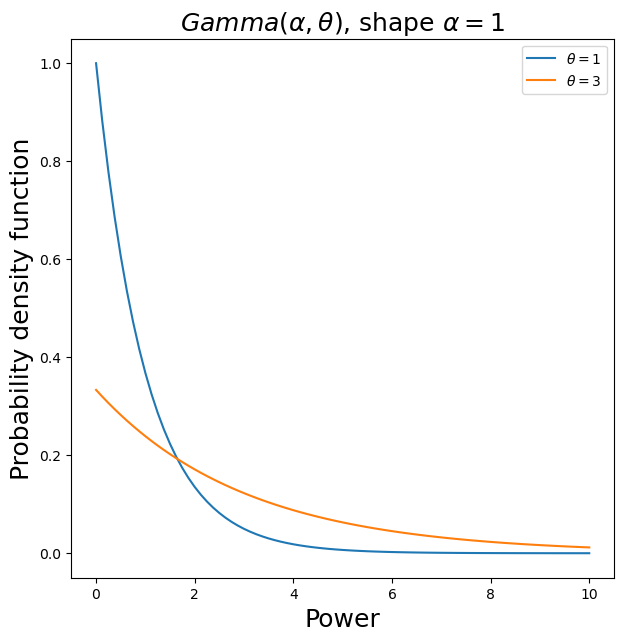

In [136]:
from scipy.stats import gamma,lognorm,norm
plt.figure(figsize=(7,7))
x=np.linspace(0,10,81)

plt.plot(x,gamma.pdf(x,1,0,1),label=r'$\theta=1$')
plt.plot(x,gamma.pdf(x,1,0,3),label=r'$\theta=3$')
#plt.plot(x,gamma.pdf(x,2,0,1),label=r'$\alpha=2, \ \theta=1$')
plt.legend()
plt.ylabel('Probability density function',fontsize=FS)
plt.xlabel('Power',fontsize=FS)
plt.title(r'$Gamma(\alpha,\theta)$'+', shape '+r'$\alpha=1$',fontsize=FS)
plt.show()

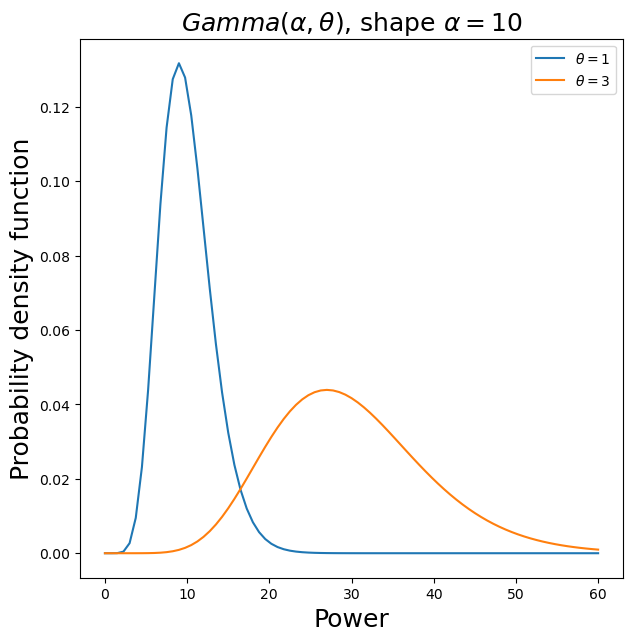

In [68]:
from scipy.stats import gamma,lognorm
plt.figure(figsize=(7,7))
x=np.linspace(0,60,81)

plt.plot(x,gamma.pdf(x,10,0,1),label=r'$\theta=1$')
plt.plot(x,gamma.pdf(x,10,0,3),label=r'$\theta=3$')
#plt.plot(x,gamma.pdf(x,2,0,1),label=r'$\alpha=2, \ \theta=1$')
plt.legend()
plt.ylabel('Probability density function',fontsize=FS)
plt.xlabel('Power',fontsize=FS)
plt.title(r'$Gamma(\alpha,\theta)$'+', shape '+r'$\alpha=10$',fontsize=FS)
plt.show()

In [ ]:
from scipy.stats import gamma,lognorm
plt.figure(figsize=(7,7))
x=np.linspace(0,8,81)

plt.plot(x,gamma.pdf(x,1,0,1),label=r'$\alpha=1, \ \theta=1$')
plt.plot(x,gamma.pdf(x,1,0,2),label=r'$\alpha=1, \ \theta=2$')
#plt.plot(x,gamma.pdf(x,2,0,1),label=r'$\alpha=2, \ \theta=1$')
plt.legend()
plt.ylabel('Probability density function')
plt.xlabel('Power')
plt.title(r'$Gamma(1,\theta)$')
plt.show()

In [5]:
Spectral_dof=2*np.ones((100,100))
Spectral_dof[0,0]=1
Spectral_dof[0,50]=1
Spectral_dof[50,0]=1
Spectral_dof[50,50]=1
Spectral_dof=Spectral_dof[:,:51]

In [6]:
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
k_vector=np.fft.fftfreq(100,0.08)
kx,ky=np.meshgrid(k_vector,k_vector)
kx=kx[:,:51]
ky=ky[:,:51]
k_reduced_grid=k_grid[:,:51]

init_freq_index=4
k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125)
#k_values=np.logspace(np.log10(0.5),np.log10(6.25),300)
Ring_masks=np.zeros((len(k_values)-init_freq_index,k_reduced_grid.shape[0],k_reduced_grid.shape[1]),dtype=bool)
Gamma_shapes=np.zeros(len(k_values)-init_freq_index)

for i in range(init_freq_index,len(k_values)):
        #Chose ring of given radius
        Ring_masks[i-init_freq_index]=np.logical_and((k_reduced_grid>=k_values[i-1]),(k_reduced_grid<k_values[i]))
        Gamma_shapes[i-init_freq_index]=Spectral_dof[Ring_masks[i-init_freq_index]].sum()/2

In [44]:
Ring_masks.sum(axis=(1,2))

array([ 11,  13,  21,  19,  25,  29,  29,  35,  33,  41,  47,  45,  49,
        49,  59,  61,  61,  63,  73,  69,  71,  77,  85,  89,  83,  85,
        97,  95, 105, 101, 105, 115, 105, 117, 115, 129, 125, 119, 137,
       133, 145, 139, 137, 149, 147, 157])

In [7]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

In [158]:
from GRF_perturbations.Modules.GRF_generation import get_Fourier_phase
Anomalies_spectra=np.zeros((1000,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,0.5]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(1000)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,True,noise_seed)
    Anomalies_images=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra[i]=np.abs(np.fft.fft2(Anomalies_images))**2

100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.96it/s]


In [159]:
Radial_spectra=np.array([ np.array([((Anomalies_spectra[j,:,:51])[Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))]) for j in tqdm(range(1000))])

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2419.34it/s]


Text(0.5, 0, '$k, \\ arcsec^{-1}$')

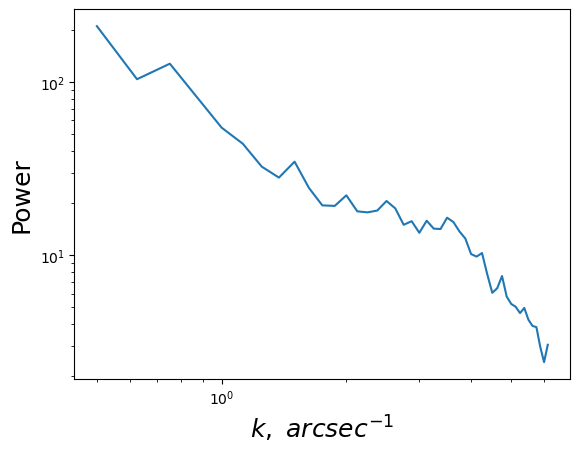

In [161]:
#plt.title('Radial power spectrum '+r'$P_{\delta I}(|k|)$',fontsize=FS)
plt.loglog(Observation_conditions.frequencies,Radial_spectra[0])
plt.ylabel('Power',fontsize=FS)
plt.xlabel(r'$k, \ arcsec^{-1}$',fontsize=FS)

Text(0.5, 1.0, 'Power spectrum $P_{\\delta I}$')

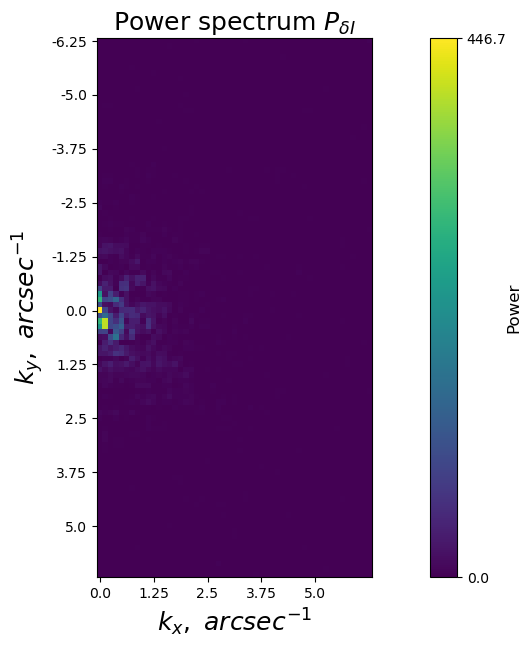

In [66]:
#spec=np.fft.fftshift(np.fft.fft2(simulated_image-Image_unperturbed_noiseless))[:,50:]
power_spec=np.fft.fftshift(Anomalies_spectra[0,:,:51],axes=0)
fig=plt.figure(figsize=(15,7))

img=power_spec
im=plt.imshow(power_spec)

ks=np.fft.fftshift(k_grid)[:,50:]

#plt.contour(ks,[1,2,4,6],colors='w')

#plt.contour(ks,Observation_conditions.frequencies[::5],colors='w',alpha=0.5)

plt.xticks(np.arange(0,50,10),kx[0,:50][::10])
plt.xlabel(r'$k_x, \ arcsec^{-1}$',fontsize=FS)
plt.yticks(np.arange(0,100,10),np.fft.fftshift(ky[:,0])[::10])
plt.ylabel(r'$k_y, \ arcsec^{-1}$',fontsize=FS)

cbar=fig.colorbar(im,ticks=[math.ceil(img.min()*1e+2)/1e+2,0,math.floor(img.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Power',rotation=90,fontsize=12,labelpad=0)

plt.title('Power spectrum '+r'$P_{\delta I}$',fontsize=FS)

Text(0.5, 0, '$k, \\ arcsec^{-1}$')

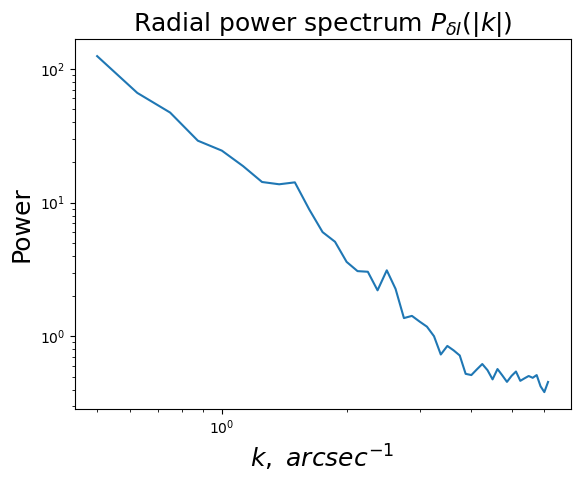

In [67]:
plt.title('Radial power spectrum '+r'$P_{\delta I}(|k|)$',fontsize=FS)
plt.loglog(Observation_conditions.frequencies,Radial_spectra[0])
plt.ylabel('Power',fontsize=FS)
plt.xlabel(r'$k, \ arcsec^{-1}$',fontsize=FS)

Text(0.5, 1.0, 'Power spectrum $P_{\\delta I}$')

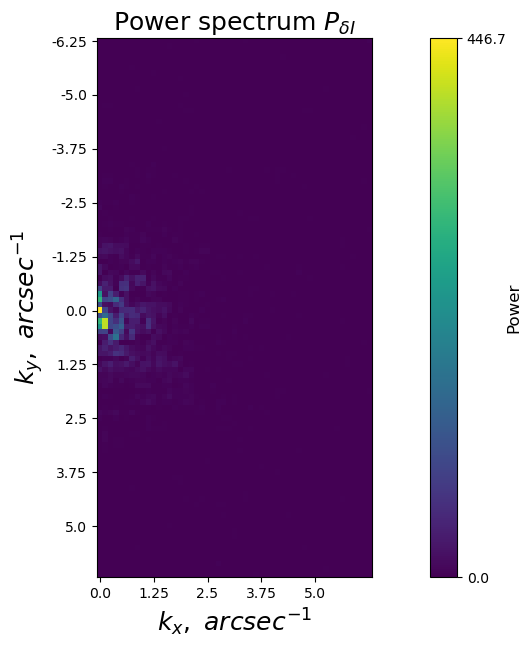

In [26]:
#spec=np.fft.fftshift(np.fft.fft2(simulated_image-Image_unperturbed_noiseless))[:,50:]
power_spec=np.fft.fftshift(Anomalies_spectra[0,:,:51],axes=0)
fig=plt.figure(figsize=(15,7))

img=power_spec
im=plt.imshow(power_spec)

ks=np.fft.fftshift(k_grid)[:,50:]

#plt.contour(ks,[1,2,4,6],colors='w')

#plt.contour(ks,Observation_conditions.frequencies[::2],colors='w',alpha=0.5)

plt.xticks(np.arange(0,50,10),kx[0,:50][::10])
plt.xlabel(r'$k_x, \ arcsec^{-1}$',fontsize=FS)
plt.yticks(np.arange(0,100,10),np.fft.fftshift(ky[:,0])[::10])
plt.ylabel(r'$k_y, \ arcsec^{-1}$',fontsize=FS)

cbar=fig.colorbar(im,ticks=[math.ceil(img.min()*1e+2)/1e+2,0,math.floor(img.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Power',rotation=90,fontsize=12,labelpad=0)

plt.title('Power spectrum '+r'$P_{\delta I}$',fontsize=FS)

Text(0.5, 0, '$k, \\ arcsec^{-1}$')

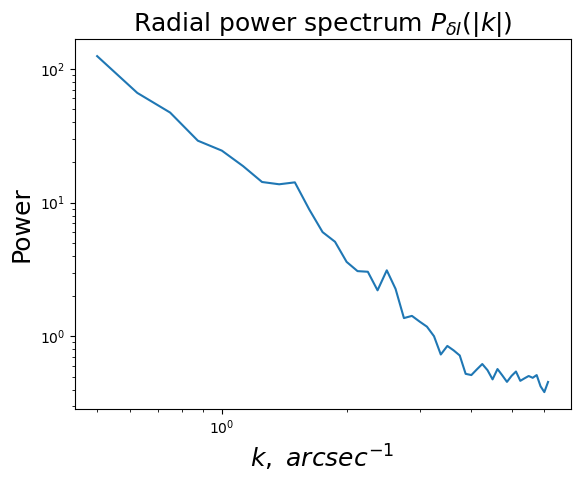

In [23]:
plt.title('Radial power spectrum '+r'$P_{\delta I}(|k|)$',fontsize=FS)
plt.loglog(Observation_conditions.frequencies,Radial_spectra[0])
plt.ylabel('Power',fontsize=FS)
plt.xlabel(r'$k, \ arcsec^{-1}$',fontsize=FS)

In [77]:
Radial_spectra.shape

(1000, 46)

In [101]:
MU_vals=np.zeros(46)
Sigma_vals=np.zeros(46)

for i in range(46):
    #LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(Radial_spectra[:,i])
    log_spec=np.log(Radial_spectra[:,i])
    MU_vals[i]=log_spec.mean()
    Sigma_vals[i]=log_spec.std()

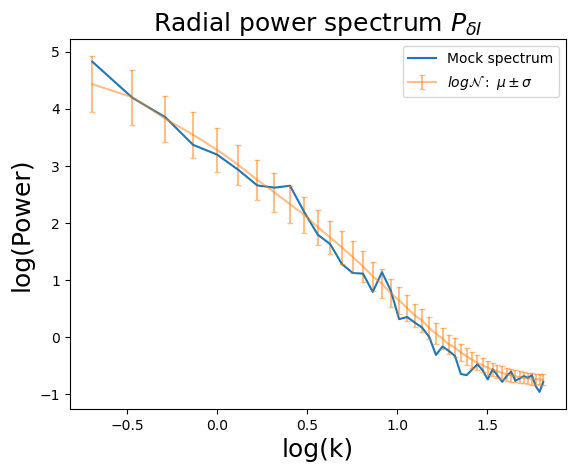

In [138]:
plt.title('Radial power spectrum '+r'$P_{\delta I}$',fontsize=FS)
plt.plot(np.log(Observation_conditions.frequencies),np.log(Radial_spectra[0]),label='Mock spectrum')
plt.errorbar(np.log(Observation_conditions.frequencies),MU_vals,Sigma_vals,alpha=0.5,capsize=2,label=r'$log\mathcal{N}: \ \mu \pm \sigma$')
plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('log(k)',fontsize=FS)
plt.legend()

Text(0.5, 0, '$k, \\ arcsec^{-1}$')

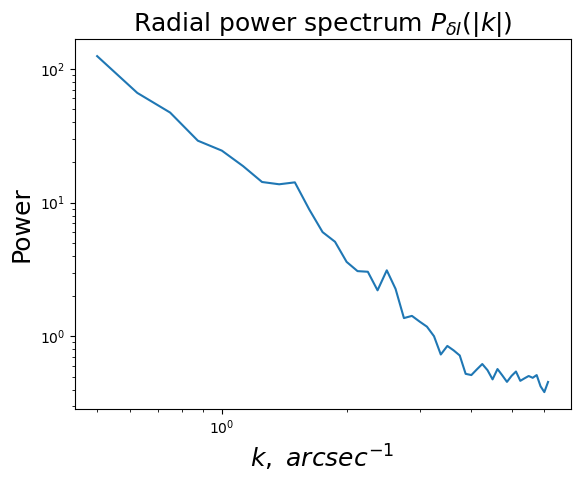

In [73]:
plt.title('Radial power spectrum '+r'$P_{\delta I}(|k|)$',fontsize=FS)
plt.loglog(Observation_conditions.frequencies,Radial_spectra[0])
plt.ylabel('Power',fontsize=FS)
plt.xlabel(r'$k, \ arcsec^{-1}$',fontsize=FS)

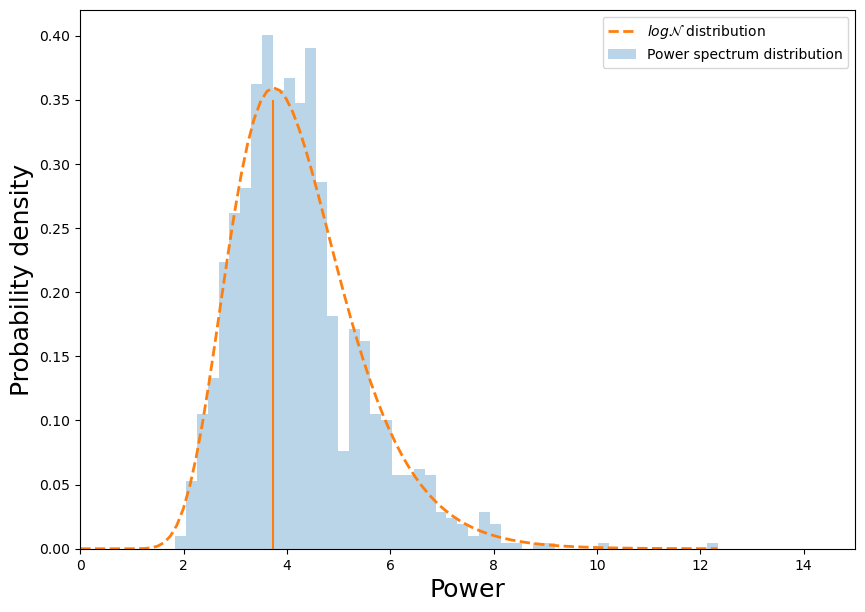

In [128]:
import scipy as sc
plt.figure(figsize=(10,7))

index_freq=16
index_rad=index_freq+1-init_freq_index

#2<=k<2.125
aggregated_spectra=(Anomalies_spectra[:,:,:51]*Ring_masks[index_rad]).sum(axis=(1,2))/(Ring_masks[index_rad].sum())
shape_marg=Ring_masks[index_rad].sum()

plt.hist(aggregated_spectra,bins=50,density=True,label='Power spectrum distribution',color='C0',alpha=0.3)

LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(Radial_spectra[:,index_rad])

x=np.linspace(0,aggregated_spectra.max(),100)
plt.plot(x,lognorm.pdf(x,s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label=r'$log\mathcal{N}$'+' distribution',linestyle='--',linewidth=2,color='C1')

#plt.vlines(x[np.argmax(lognorm.pdf(x,s=LN_sigma,loc=0,scale=np.exp(LN_mu)))],0,0.35,color='C1')
#plt.hlines(x[np.argmax(lognorm.pdf(x,s=LN_sigma,loc=0,scale=np.exp(LN_mu)))]-LN_sigma,0,0.35,color='C1')



plt.xlim(0,15)
plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

In [153]:
np.log(Observation_conditions.frequencies[index_rad])

0.7537718023763802

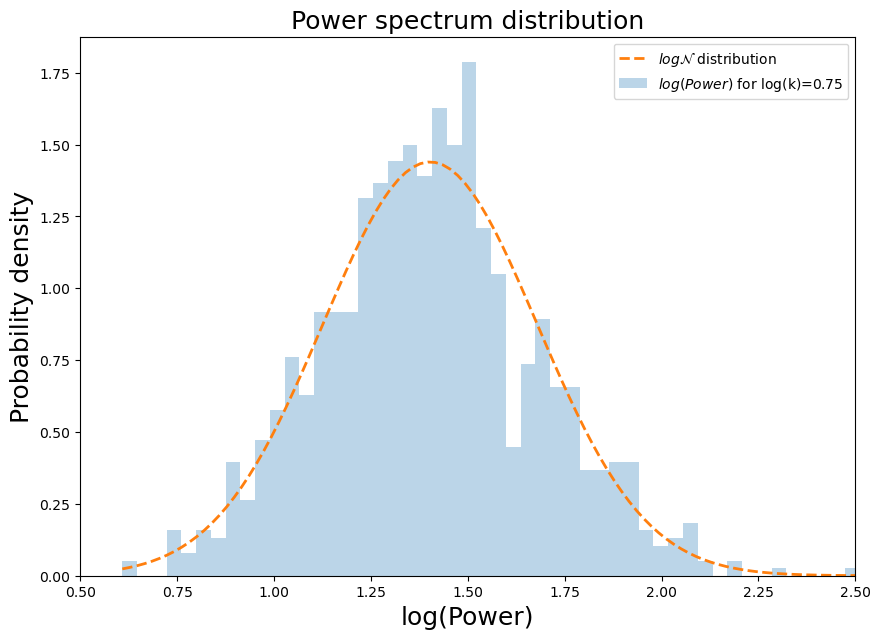

In [157]:
import scipy as sc
plt.figure(figsize=(10,7))

index_freq=16
index_rad=index_freq+1-init_freq_index

plt.hist(np.log(Radial_spectra[:,index_rad]),bins=50,density=True,label=r'$log(Power)$'+' for log(k)=0.75',color='C0',alpha=0.3)

#LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(Radial_spectra[:,index_rad])

x=np.linspace(np.log(Radial_spectra[:,index_rad]).min(),np.log(Radial_spectra[:,index_rad]).max(),100)
plt.plot(x,norm.pdf(x,MU_vals[index_rad],Sigma_vals[index_rad]),label=r'$log\mathcal{N}$'+' distribution',linestyle='--',linewidth=2,color='C1')




plt.xlim(0.5,2.5)
plt.xlabel('log(Power)',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.title('Power spectrum distribution',fontsize=FS)
plt.legend()
plt.show()

# Prediction

In [2]:
grid_size=128
logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
GRF_seeds_number=100

In [3]:
Spectra_grid=np.load('../Processing_scripts/results/Radial_spectra/Spectra_grid.npz')['arr_0']

In [35]:
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:227: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


In [4]:
MU_tensor=np.log(Spectra_grid).mean(axis=2)
MU_tensor_ext=np.tile(MU_tensor,GRF_seeds_number)
MU_tensor_ext=MU_tensor_ext.reshape((grid_size,grid_size,GRF_seeds_number,Spectra_grid.shape[-1]))
Sigma_tensor=np.sqrt(np.power(np.log(Spectra_grid)-MU_tensor_ext,2).sum(axis=2)/(Spectra_grid.shape[2]-1))

In [12]:

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)
    
def plot_line(ax_row,data_image,residuals_image,GRF_potential,likelihood,Confidence_grid,SNR,\
              true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,manual_locations,\
              logA_ind_lim=(0,160),Beta_ind_lim=(0,214),legend_flag=True,titles_flag=True):
    #Data
    im=ax_row[0].imshow(data_image)
    cbar=fig.colorbar(im,ax=ax_row[0],ticks=[0,0.2,0.4,0.6,math.floor(data_image.max()*100)/100],fraction=0.045)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
    
    #Potential
    im=ax_row[1].imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[1],ticks=[math.ceil(GRF_potential.min()*1e+3)/1e+3,0,math.floor(GRF_potential.max()*1e+3)/1e+3],fraction=0.045)
    cbar.ax.set_ylabel(r'$\delta \psi$',rotation=90,fontsize=12,labelpad=0)
    
    #masked_resid=resids_images[i]*mask
    #norm_masked_resid=(resids_images[i]/np.sqrt(noise_vars[i]))*mask
    
    #Residuals
    normalised_masked_residuals=(residuals_image*Observation_conditions.annulus_mask)/np.sqrt(noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    
    im=ax[i,2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[2],ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    #fig.colorbar(im,ax=ax[i,2],ticks=[math.ceil(resids_images[i].min()*1e+3)/1e+3,0,math.floor(resids_images[i].max()*1e+3)/1e+3],fraction=0.045)
    
    
    Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
    Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_SNR=SNR[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
    Like_xticks=np.arange(10)
    Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
    Like_yticks=np.arange(0,8)*0.5-9.5
    Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]
    
    
    plot_likelihood(ax_row[3],Crop_Beta_arr,Crop_logA_arr,Crop_confidence,Crop_SNR,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,manual_locations,legend_flag)
    
    ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0
    
    for j in range(3):
        ax_row[j].set_xticks([0,50,100-1])
        ax_row[j].set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
        ax_row[j].set_xlabel('arcsec')
        
        ax_row[j].set_yticks([0,50,100-1])
        ax_row[j].set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
        ax_row[j].set_ylabel('arcsec',labelpad=-15)

        
    if titles_flag:
        titles=['Imaging data','Potential perturbations','Normalised residuals','Perturbations confidence']
        for j in range(4):
            ax_row[j].set_title(titles[j],fontsize=FS)


def conduct_inference(GRF_params,GRF_seed_index):
    get_GRF=Inference.GRF_getters(True)
    GRF_potential=get_GRF(GRF_params,GRF_seed_index)

    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

    simulate_perturbed_image=Observation_conditions.perturbed_image_getter
    simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)
    
    args_fit=Inference.differentiable_fit_image(simulated_image)

    simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
    fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

    residuals=simulated_image-fit_image
    spectrum=Inference.compute_radial_spectrum(residuals)

    true_logA_index=np.argmin(np.abs(logA_array-GRF_params[0]))
    true_Beta_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

    likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,logA_conf_regions,Beta_conf_regions=Inference_pipeline(spectrum,MU_tensor,Sigma_tensor)
    logA_maxL_index,Beta_maxL_index=jnp.unravel_index(jnp.argmax(likelihood),likelihood.shape)
    
    return GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index

In [18]:
def plot_noSNR_likelihood(axis,Beta_array,logA_array,confidence_grid,true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,xticks,yticks,manual_locations,legend=False,fontsize=18):

    #Confidence levels
    #smooth the grid to avoid sharp edged contours
    smooth_confidence_grid=sc.ndimage.gaussian_filter(confidence_grid,sigma=(2,2))
    imgCont=axis.contourf(Beta_array,logA_array,smooth_confidence_grid,[0,0.39347,0.86466,0.988891],colors=['red','indianred','rosybrown','w'],alpha=0.7)

    img=axis.contour(Beta_array,logA_array,smooth_confidence_grid,[0.39347,0.86466,0.988891],colors='k')


    fmt = {}
    strs = [r'$1\sigma$',r'$2\sigma$',r'$3\sigma$']
    for l,s in zip( img.levels, strs ):
        fmt[l] = s

    #manual_locations=[(5,20)]
    axis.clabel(img,[0.988891],inline=True,fmt={0.988891: '$3\\sigma$'},fontsize=15,manual=manual_locations[0])
    #manual_locations=[(5,20)]
    axis.clabel(img,[0.86466],inline=True,fmt={0.86466: '$2\\sigma$'},fontsize=15,manual=manual_locations[1])
    #manual_locations=[(5,20)]
    axis.clabel(img,[0.39347],inline=True,fmt={0.39347: '$1\\sigma$'},fontsize=15,manual=manual_locations[2])

    #Prediction and truth

    predPoint=axis.scatter(Beta_array[pred_Beta_index],logA_array[pred_logA_index],label='Max likelihood',marker="o",s=80,color='k',edgecolor='w',linewidth=0.5)
    truePoint=axis.scatter(Beta_array[true_Beta_index],logA_array[true_logA_index],label='Ground truth',marker="*",s=80,color='k',edgecolor='w',linewidth=0.5)


    axis.set_xticks(xticks)
    axis.set_yticks(yticks)
    axis.set_xlabel(r'$\beta$',fontsize=fontsize)
    axis.set_ylabel(r"${\rm log}(A)$",fontsize=fontsize)

    #axis.set_xticklabels([1,2,3,4,5])
    #.xticks([1,2,3,4,5])
    #plt.yticks([-9,-8.5,-8,-8.5,-7.5,-7])

    if legend:
        l=axis.legend([truePoint,predPoint,plt.Rectangle((1, 1), 2, 2, fc=imgCont.collections[0].get_facecolor()[0])],['Ground truth','Max likelihood','Confidence regions'],loc='lower right',fontsize=15,framealpha=0)
        for text in l.get_texts():
            text.set_color("k")

In [14]:
results_high_SNR=conduct_inference([-7.5,2],2)

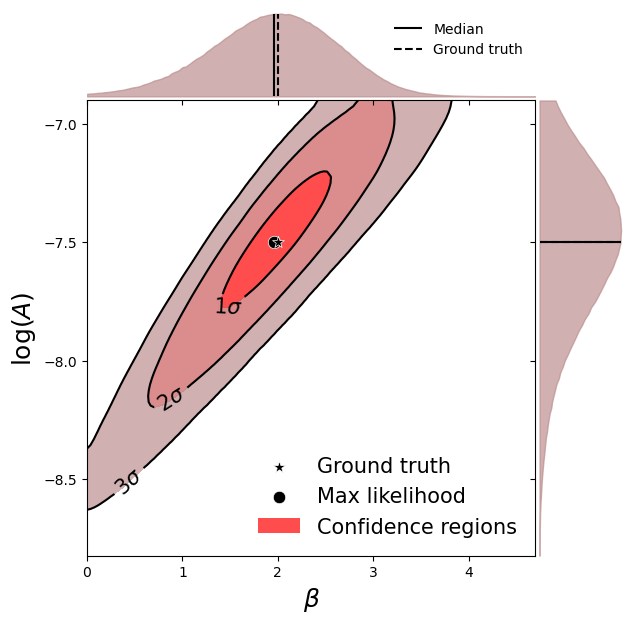

In [19]:
import seaborn as sns
import scipy as sc

GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
    results_high_SNR

res_matrix=get_conf_intervals(likelihood)
pred_logA_index,pred_Beta_index=res_matrix[0]
logA_conf_regions=res_matrix[1:4]
Beta_conf_regions=res_matrix[4:]

g = sns.JointGrid(space=0)

logA_ind_lim=(50,128)
Beta_ind_lim=(0,128)
legend_flag=True
manual_locations=[[(4,-10)],[(4,-10)],[(4,-10)]]

Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
Like_xticks=np.arange(10)
Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
Like_yticks=np.arange(0,8)*0.5-9.5
Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]

plot_noSNR_likelihood(g.ax_joint,Crop_Beta_arr,Crop_logA_arr,Crop_confidence,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,manual_locations,legend_flag)

#g.ax_marg_x.plot(np.arange(0,len(Crop_logA_arr)),likelihood[:,:].mean(axis=0))

Beta_likelihood=likelihood.mean(axis=0)
logA_likelihood=likelihood.mean(axis=1)



g.ax_marg_x.fill_between(Crop_Beta_arr,0,Beta_likelihood,color='rosybrown',alpha=0.7)
g.ax_marg_y.fill_betweenx(Crop_logA_arr,logA_likelihood[50:],color='rosybrown',alpha=0.7)


g.ax_marg_x.vlines(Crop_Beta_arr[pred_Beta_index],0,Beta_likelihood[pred_Beta_index],color='k',linestyle='-',label='Median')
g.ax_marg_y.hlines(Crop_logA_arr[pred_logA_index-50],0,logA_likelihood[pred_logA_index],color='k',linestyle='-')


g.ax_marg_x.vlines(Crop_Beta_arr[true_Beta_index],0,Beta_likelihood[true_Beta_index],color='k',linestyle='--',label='Ground truth')
g.ax_marg_y.hlines(Crop_logA_arr[true_logA_index-50],0,logA_likelihood[true_logA_index],color='k',linestyle='--')

g.ax_marg_x.legend(loc='upper right',framealpha=0)

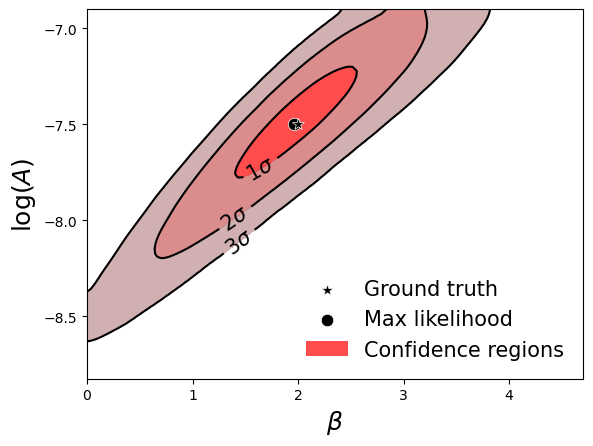

In [20]:
fig,ax=plt.subplots(1,1)

plot_noSNR_likelihood(ax,Crop_Beta_arr,Crop_logA_arr,Crop_confidence,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,manual_locations,legend_flag)

In [230]:
logA_conf_regions[0]

DeviceArray([ 89, 115], dtype=int64)

In [232]:
logA_array[logA_conf_regions[0,0]]-logA_array[pred_logA_index]

-0.34999999999999964

In [233]:
logA_array[logA_conf_regions[0,1]]-logA_array[pred_logA_index]

0.2999999999999998

# No lens

In [257]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time,lens_mass_model_list=[],kwargs_lens_mass = [])

In [258]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

(-0.5, 99.5, 99.5, -0.5)

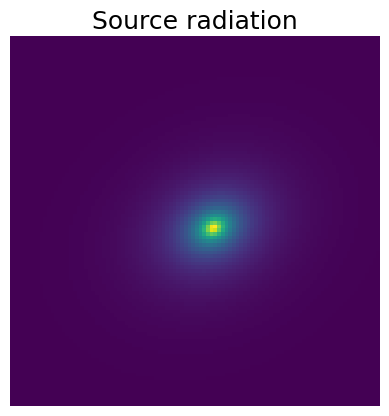

In [259]:
plt.imshow(Image_unperturbed_noiseless)
plt.title('Source radiation',fontsize=FS)
plt.axis('off')

In [244]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)


In [245]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

(-0.5, 99.5, 99.5, -0.5)

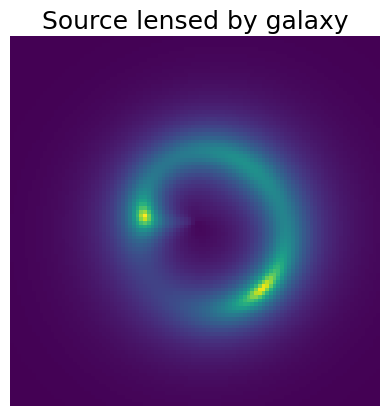

In [255]:
plt.imshow(Image_unperturbed_noiseless)
plt.title('Source lensed by galaxy',fontsize=FS)
plt.axis('off')

In [247]:
GRF_params=[-7,2]
get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF([-7,3],1)
initial=deepcopy(GRF_potential)

Text(0.5, 1.0, 'Source lensed by galaxy \n and satellites')

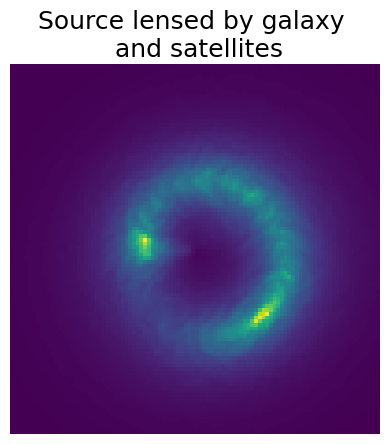

In [256]:
GRF_params=[-7.6,2.]
GRF_seed_index=2

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,False,noise_seed)

plt.imshow(simulated_image)
plt.axis('off')
plt.title('Source lensed by galaxy \n and satellites',fontsize=FS)

# Metaanalysis

In [21]:
Prediction_grid=np.load('../Processing_scripts/results/prediction/Predictions_grid_node_0.npz')['arr_0']

for i in range(1,4):
    Prediction_grid=np.append(Prediction_grid,np.load('../Processing_scripts/results/prediction/Predictions_grid_node_{}.npz'.format(i))['arr_0'],axis=0)

In [27]:
predicted_indices=Prediction_grid[:,:,:,0]
logA_confidence_regions=Prediction_grid[:,:,:,1:4]
Beta_confidence_regions=Prediction_grid[:,:,:,4:]

In [28]:
predicted_bias=np.zeros((len(logA_array),len(Beta_array),100,2))

uncertainty_width=np.zeros((len(logA_array),len(Beta_array),100,2,3))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(len(logA_array)):
    for j in range(len(Beta_array)):
        
        logA_uncertainty_width=logA_confidence_regions[i,j,:,:,1]-logA_confidence_regions[i,j,:,:,0]
        Beta_uncertainty_width=Beta_confidence_regions[i,j,:,:,1]-Beta_confidence_regions[i,j,:,:,0]
        
        #(sigma_top+sigma_bot)/2
        uncertainty_width[i,j,:,0,:]=logA_uncertainty_width/2
        uncertainty_width[i,j,:,1,:]=Beta_uncertainty_width/2
        
        predicted_bias[i,j,:,0]=(predicted_indices[i,j,:,0]-true_indices[0][i])
        predicted_bias[i,j,:,1]=(predicted_indices[i,j,:,1]-true_indices[1][j])
        

mean_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).mean(axis=-2)
std_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).std(axis=-2)

In [29]:
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]

X,Y=np.meshgrid(np.arange(len(Beta_array)),np.arange(len(logA_array)))

images=[np.sqrt(I**2+J**2),std_bias[:,:,0],std_bias[:,:,1]]
titles=[r'$\mu$',r'$\sigma_{logA}$',r'$\sigma_{\beta}$']

In [42]:
from matplotlib.legend_handler import HandlerTuple
from skimage import measure
def make_logA_uncertainty_figure(axis,uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,limit_amplitude=-9,\
                                 clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=1):
    
    sigma=1
    Uncertainty=uncertainty_width.mean(axis=2)[:,:,0,sigma-1]*(logA_array[1]-logA_array[0])
    Uncertainty[Uncertainty>limit_uncertainty]=limit_uncertainty

    
    Zero_SNR_indices=measure.find_contours(SNR_grid,0)[0]
    Zero_SNR_indices=np.array(Zero_SNR_indices).round().astype(int).T
    Zero_SNR_uncertainty=Uncertainty[Zero_SNR_indices[0],Zero_SNR_indices[1]].max()
    #Uncertainty image
    img_arr+=[axis.imshow(Uncertainty,cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(Zero_SNR_uncertainty))]
    
    #Contours of uncert
    smooth_amplitude=sc.ndimage.gaussian_filter(Uncertainty,1,mode='constant')
    smooth_amplitude[:,-2:]=Uncertainty[:,-2:]
    smooth_amplitude[:,:2]=Uncertainty[:,:2]
    '''
    imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.3,0.35],colors='k',linewidths=linewidths)
    
    clabels=axis.clabel(imgCont,[0.35],inline=True,fmt={0.35: '$\\sigma=0.35$'},\
                        fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.3],inline=True,fmt={0.3: '$\\sigma=0.3$'},\
                fontsize=clabel_fontsize,manual=manual_locations[1],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.25],inline=True,fmt={0.25: '$\\sigma=0.25$'},\
                fontsize=clabel_fontsize,manual=manual_locations[2],inline_spacing=inline_spacing)
    '''
    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                         fontsize=clabel_fontsize,manual=manual_locations[3],inline_spacing=inline_spacing)
    
    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)
    
    labelstep=15
    #Y axis
    axis.invert_yaxis()
    
    axis.set_yticks(np.arange(0,len(logA_array),labelstep))
    axis.set_yticklabels(logA_array[::labelstep].round(1))
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)

    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)
    
    #X axis
    axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)
    
    #Title and colorbar
    axis.set_title('log(A) uncertainty',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0.1,0.25,0.35,0.45,0.6],fraction=0.03)
    cbar.ax.set_ylabel('log(A) units',rotation=90,fontsize=labels_fontsize,labelpad=5)
    
    blue_patch = mpatches.Patch(color=mpl.cm.get_cmap('coolwarm')(0.3))
    #axis.legend([blue_patch,imgCont.collections[0],imgSNR.collections[0]], [r'$\sigma_{log(A)}$',r'$\sigma=const$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')
    axis.legend([blue_patch,imgSNR.collections[0]], [r'$\sigma_{log(A)}$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')

    
    
    return img_arr

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_23569/1356380988.py:33: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


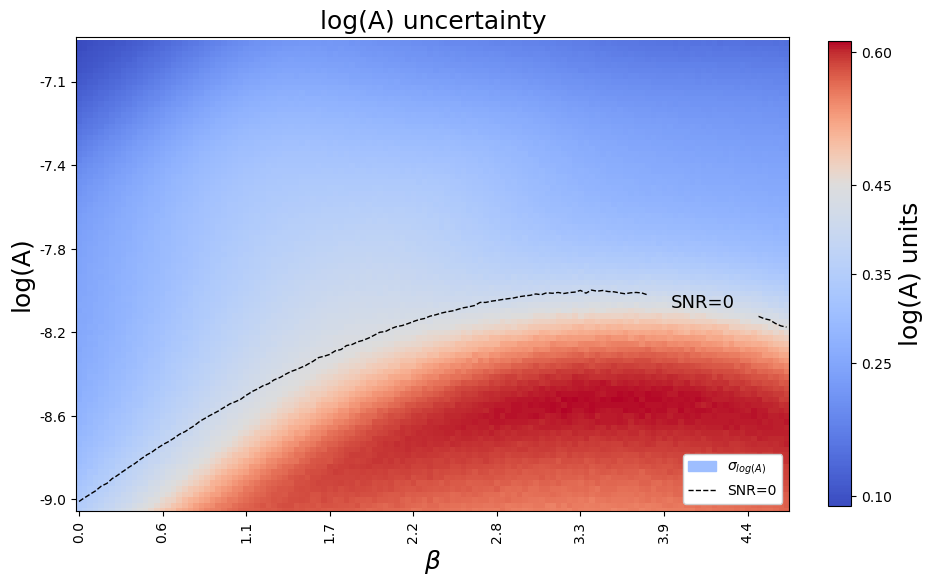

In [67]:
fig,ax=plt.subplots(1,1,figsize=(10,7))

img_arr=[]
manual_locations=[[(110,60)],[(110,60)],[(110,60)],[(110,60)]]
img_arr=make_logA_uncertainty_figure(ax,uncertainty_width,img_arr,manual_locations,limit_uncertainty=1,\
                                    labels_fontsize=FS,inline_spacing=30,clabel_fontsize=13)

In [54]:
def make_Beta_uncertainty_figure(axis,uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,limit_amplitude=-9,\
                                 clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=1):
    
    sigma=1
    Uncertainty=uncertainty_width.mean(axis=2)[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0])
    Uncertainty[Uncertainty>limit_uncertainty]=limit_uncertainty

    Zero_SNR_indices=measure.find_contours(SNR_grid,0)[0]
    Zero_SNR_indices=np.array(Zero_SNR_indices).round().astype(int).T
    Zero_SNR_uncertainty=Uncertainty[Zero_SNR_indices[0],Zero_SNR_indices[1]].max()
    #Uncertainty image
    img_arr+=[axis.imshow(Uncertainty,cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(Zero_SNR_uncertainty))]
    
    #Contours of uncert
    smooth_amplitude=sc.ndimage.gaussian_filter(Uncertainty,1,mode='constant')
    smooth_amplitude[-2:,:]=Uncertainty[-2:,:]
    smooth_amplitude[:,-2:]=Uncertainty[:,-2:]
    smooth_amplitude[:,:2]=Uncertainty[:,:2]
    '''
    imgCont=axis.contour(X,Y,smooth_amplitude,[0.5,0.7,0.9],colors='k',linewidths=linewidths)
    
    clabels=axis.clabel(imgCont,[0.9],inline=True,fmt={0.9: '$\\sigma=0.9$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.7],inline=True,fmt={0.7: '$\\sigma=0.7$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[1],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.5],inline=True,fmt={0.5: '$\\sigma=0.5$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[2],inline_spacing=inline_spacing)
    '''
    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths)
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                          fontsize=clabel_fontsize,manual=manual_locations[3],inline_spacing=inline_spacing)
    
    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)
    
    labelstep=15
    #Y axis
    axis.invert_yaxis()
    
    axis.set_yticks(np.arange(0,len(logA_array),labelstep))
    axis.set_yticklabels(logA_array[::labelstep].round(1))
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)

    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)
    
    #X axis
    axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)
    
    #Title and colorbar
    axis.set_title(r'$\beta$'+' uncertainty',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0.2,0.4,0.6,0.8,1,1.2,1.4],fraction=0.03)
    cbar.ax.set_ylabel(r'$\beta$'+' units',rotation=90,fontsize=labels_fontsize,labelpad=0)
    
    
    cbar.ax.set_yticklabels(['0.2','0.4','0.6','0.8','1','1.2','1.4'])
    
    blue_patch = mpatches.Patch(color=mpl.cm.get_cmap('coolwarm')(0.3))
    #axis.legend([blue_patch,imgCont.collections[0],imgSNR.collections[0]], [r'$\sigma_{\beta}$',r'$\sigma=const$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')
    axis.legend([blue_patch,imgSNR.collections[0]], [r'$\sigma_{\beta}$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')
    
    return img_arr

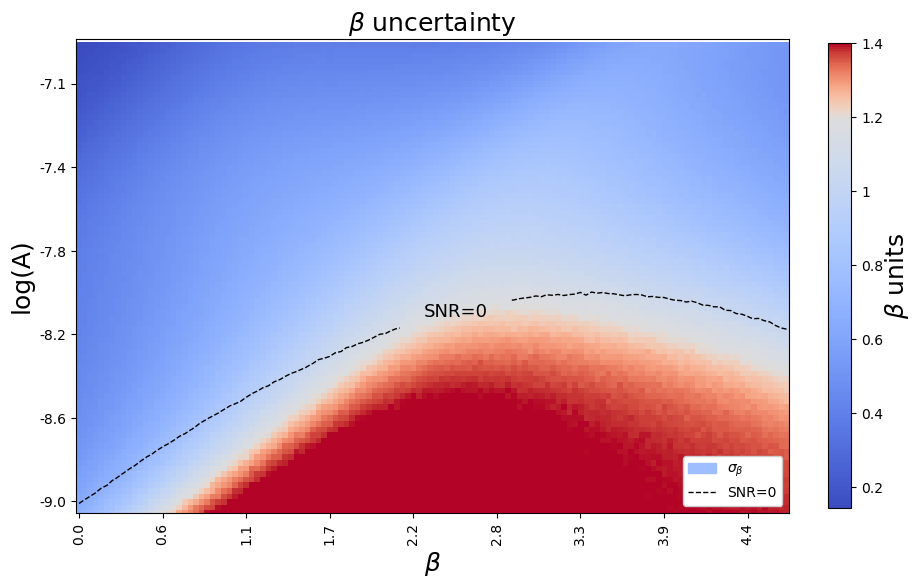

In [62]:
fig,ax=plt.subplots(1,1,figsize=(10,7))

img_arr=[]
manual_locations=[[(70,60)],[(70,60)],[(70,60)],[(70,60)]]
img_arr=make_Beta_uncertainty_figure(ax,uncertainty_width,img_arr,manual_locations,limit_uncertainty=1.4,\
                                     labels_fontsize=FS,inline_spacing=30,clabel_fontsize=13)